# Online News Popularity Classification
## -model fitting and selection

### Xian Lai
xlai4@fordham.edu

=======================================================
<img src="imgs/title_image.png" width="1200">

In [1]:
import pandas as pd
import numpy as np
import pickle
import sys; sys.path.append('modules')
from Visual import Visual as V
from LearningPipe import LearningPipe as lp

from KDE_naive_bayes import KDENB as nb
from sklearn.linear_model import LogisticRegression as lr
from sklearn.svm import SVC as svc
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.ensemble import RandomForestClassifier as rf
from xgboost import XGBClassifier as xgb

/Users/LAI/anaconda/envs/xgboost/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 0. Pre-setting

### Data set:
The dataset is cleaned, standarized in the previous preprocessing phase and saved to npz files. We directly load them in this notebook.

In the this part of project, I will test **6 classifiers**:
    1. Naive Bayes
    2. Logistic Regression
    3. SVM
    4. k-Nearest Neighbours
    5. Random Forest
    6. XGBoost

In different **Feature spaces**:
    1. original
    2. PCA
    3. sparsePCA
    4. FactorAnalysis
    5. NMF
    
### Feature Selection:
Before fitting models on the dataset, I use the extra tree model to select the most informative features to deduce the dimensionality. So the chance of overfitting and the running time of algorithms is reduced.
    
### Model optimization:
All the classifiers above have hyperparameter to tune except naive Bayes. To avoid overfitting, I will test each hyperparameter combination on the training set using 5-fold cross validation. And evaluate the performance using function explained below. 

### Performance Evaluation:
As explained with great detail in "Pattern Recognition and Machine Learning" (Bishop, 2011), the expected error can be expressed as:

$$Error = Bias^2 + Variance + (Noise)$$

In which the squared bias is the distance from expectation of prediction to the target value. In the case of classification, the distance from target value to correct prediction is 0 and to wrong prediction is 1. Since we are using 5-fold cross validation, $bias = mean(1 - accuracy) = 1 - mean(accuracy)$. And the variance is $var(accuracy)$.

\*Because the noise term discribes the noise come with the data set, it is not reducible by tuning model, we don't consider it in the performance evaluation. 

In [2]:
np.random.seed(seed=666)

clfNames   = [
    'Naive Bayes', 'Logistic Regression', 'SVM', 
    'k-Nearest Neighbours', 'Random Forest', 'XGBoost'
]
spaceNames = [
    'original', 'PCA', 'sparsePCA', 'factorAnalysis', 'NMF'
]
dimPairs   = [[0,1], [1,2], [2,3], [3,4]]

X_train_space = np.load("data/clean_dataset/X_train_space.npz")
X_test_space  = np.load("data/clean_dataset/X_test_space.npz")
y_train       = np.fromfile('data/clean_dataset/y_train', dtype=int)
y_test        = np.fromfile('data/clean_dataset/y_test', dtype=int)

# feature selection
Xs_train = {}; Xs_test = {}

for space in spaceNames:
    Xs_train[space], Xs_test[space] = lp.featureSelection(
        X_train_space[space], X_test_space[space], y_train
    )
    print("Space: {0:17} n_features: {1}"\
          .format(space, Xs_train[space].shape[1]))

Space: original          n_features: 14
Space: PCA               n_features: 14
Space: sparsePCA         n_features: 16
Space: factorAnalysis    n_features: 29
Space: NMF               n_features: 15


# 1. naive_bayes:

We start with the simple generative model naive Bayes. As we can see in feature histograms below, each feature has slightly different distributions in 2 classes. So it makes sense to try naive Bayes.

But these features have more than 1 type of distributions. Some of them are normal, some of them are exponential and there are even ones not typical and multimodal. So we can't directly use Gaussian naive Bayes or Bernoulli naive Bayes. To accommodate various types of distributions, I implemented a naive Bayes classifier using Gaussian KDE as distribution estimator.

\*Due to the large amount of time needed for grid searching, I will directly import the results generated before hand.

In [3]:
# v = V(5, 4, figsize=(18,10))
# v.plotHists(Xs_train, y_train, [0,1,2,3], spaceNames)

![hists_in_spaces](imgs/hists_in_spaces.png)

In [4]:
# models_nb = lp(nb, 'NaiveBayes', Xs_train, y_train)
# models_nb.gridSearching()

with open('data/performances/models_nb.pickle', 'rb') as f:
    models_nb = pickle.load(f)
    
models_nb.results

confusionHist  expectedLoss      mean  \
0  [[[0.442221675233, 1.16941603206, 1.2219409196...      0.144518  0.619904   
1  [[[0.0, 0.160880933595, 0.947907212052, 1.7494...      0.149589  0.613249   
2  [[[0.662265455523, 1.46812278507, 1.2779230586...      0.151495  0.610791   
3  [[[0.0, 0.345739027533, 1.36689958799, 1.69902...      0.151809  0.610410   
4  [[[0.0173511307085, 0.565361315416, 1.17974113...      0.165325  0.593414   

            space  variance  
0       sparsePCA  0.000045  
1             PCA  0.000013  
2        original  0.000011  
3             NMF  0.000028  
4  factorAnalysis  0.000013

As the grid searching results shows, although naive Bayes classifier performs a little better in sparsPCA space than in the other spaces, the accuracy is still quite low.

In general, naive Bayes is a relatively simple generative model. It simplifies and factorizes the joint distribution into the product of distributions of each single random variable, so it can not capture the relationships between variables thus the decision boundarys are always distributed parallel to axes. 

As we can see in the scatter and decision boundary plots, the data points of 2 class are mixing together. Without new features, we can't make good predictions.

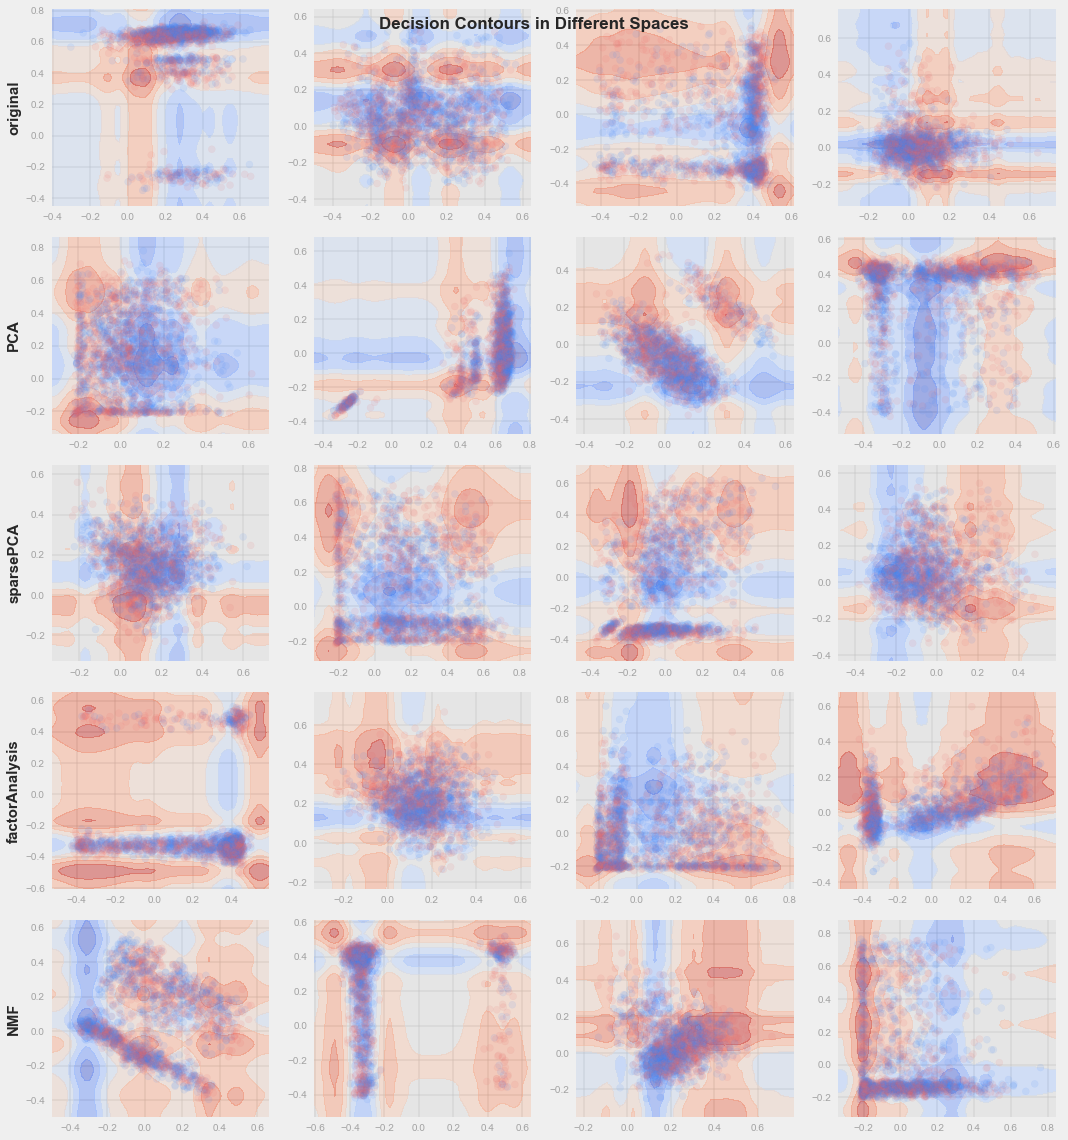

In [5]:
models_nb.plotDecisionContours(dimPairs, 4)

# 2. Logistic Regression:

Next we move on to the simple discriminative classifier logistic regression. We will test how this low capacity model works on our dataset and then go on to other higher-capacity families of models. 

From the scatter plots in feature engineering section we can tell the data points in any of those 5 spaces are not linear separable. In order to draw non-linear decision boundary and incorporate possible relationships between pairs of features, we can map the features into higher dimensional polynomial space. In this project, we will set degree equals 2.(We will test the situation of degree=3 with polynomial kernel in support vector machine)

In [6]:
Xs_train_poly = {}; Xs_test_poly = {}

for space in spaceNames:
    Xs_train_poly[space], Xs_test_poly[space] = lp.polynomializeFeatures(
        Xs_train[space], Xs_test[space], n_degree=2
    )

### Tune model in different feature space:

Grid search is performed on parameters:
    1. Regularization type(penalty): ['l1', 'l2']
    2. Regularization coefficient(C): [1, 10, 100, 1000, 2000]
    3. Maximum Iterations(max_iter): [100, 200, 500]

In [7]:
params_lr = {
    'penalty':['l1', 'l2'], 
    'C':[1, 10, 100, 1000, 2000], 
    'max_iter':[100, 200, 500]
}

# models_lr = lp(lr, 'LogisticRegression', Xs_train_poly, y_train)
# models_lr.gridSearching(params=params_lr)

with open('data/performances/models_lr.pickle', 'rb') as f:
    models_lr = pickle.load(f)

The performances are much better than that of naive Bayes classifiers. The mean accuracies are much higher and the variances are relatively low. 

In [8]:
models_lr.results.head(n=10)

C                                      confusionHist  expectedLoss  \
0   100  [[[0.0541211065235, 0.678542385197, 1.24286203...      0.117765   
1   100  [[[0.0548894363407, 0.677656956861, 1.24227629...      0.117766   
2  1000  [[[0.0564241762777, 0.681616987274, 1.24010982...      0.117834   
3  1000  [[[0.0564241762777, 0.681616987274, 1.24010982...      0.117834   
4  1000  [[[0.0564241762777, 0.681616987274, 1.24010982...      0.117834   
5  1000  [[[0.0572294416363, 0.685101124799, 1.23613333...      0.117857   
6   100  [[[0.0537346311029, 0.672353706901, 1.24918439...      0.117972   
7  1000  [[[0.0572177516324, 0.6857337938, 1.2366083390...      0.118005   
8  2000  [[[0.0572474817179, 0.686479699164, 1.23574400...      0.118032   
9  2000  [[[0.0575958946194, 0.686354966794, 1.23554679...      0.118034   

   max_iter      mean penalty           space  variance  
0       500  0.656862      l1  factorAnalysis  0.000022  
1       200  0.656862      l1  factorAnalysis  0.000022  
2       100  0.656777      l2  factorAnalysis  0.000031  
3       500  0.656777      l2  factorAnalysis  0.000031  
4       200  0.656777      l2  factorAnalysis  0.000031  
5       200  0.656735      l1  factorAnalysis  0.000025  
6       100  0.656565      l1  factorAnalysis  0.000024  
7       500  0.656523      l1  factorAnalysis  0.000028  
8       200  0.656480      l1  factorAnalysis  0.000026  
9       500  0.656480      l1  factorAnalysis  0.000029

For each of the hyperparameters:
- **Feature Space**: All top 10 performances are generated in factor analysis feature space.
- **Regularization Type(penalty)**: Most of the good models prefers using L1 as the regularization method.
- **Regularization Coefficient(C)**: In general, the dataset requires high regularization coefficient.
- **Maximum Iterations(max_iter)**: But the maximum iterations seems irrelevant. Some models stop early can also achive good performance.

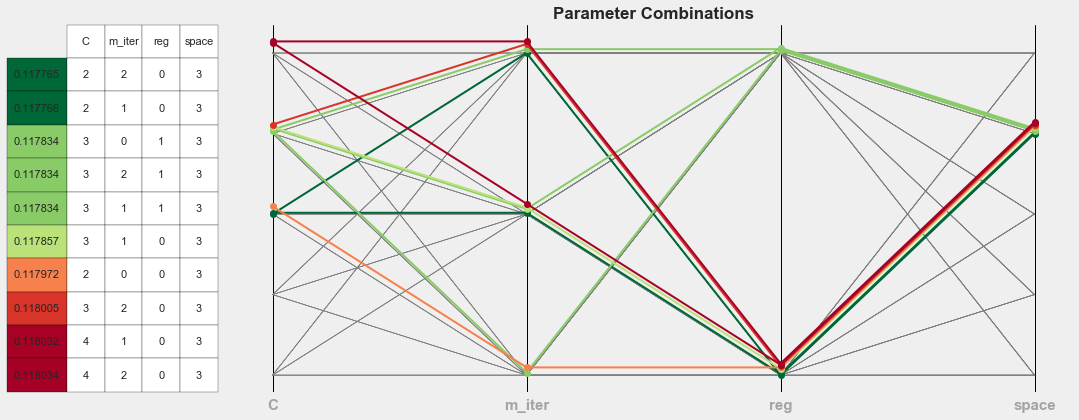

In [9]:
replaceCol = {'max_iter':'m_iter', 'penalty':'reg'}
models_lr.plotParamGrid(params_lr, replace=replaceCol)

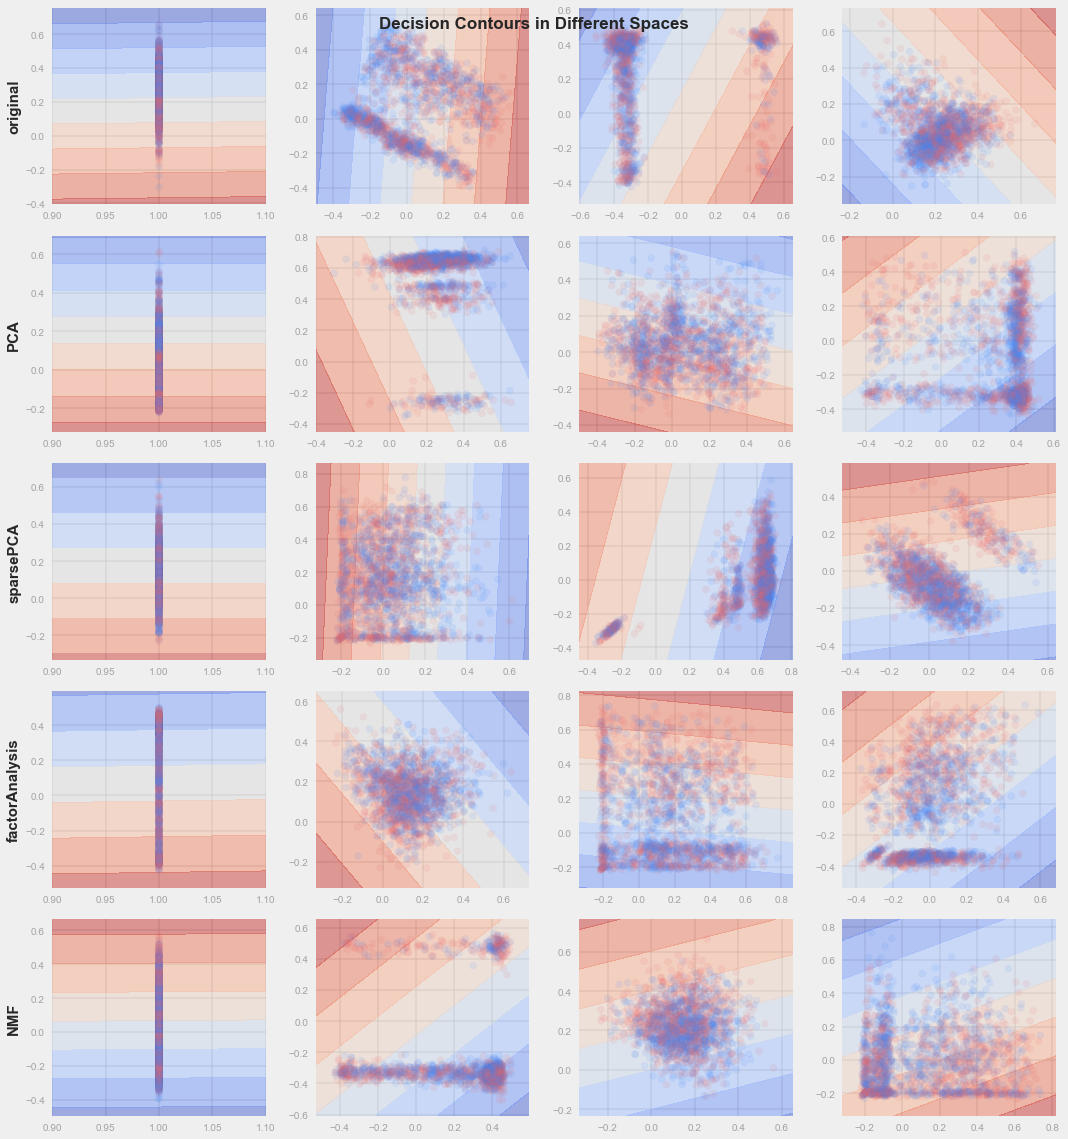

In [10]:
models_lr.plotDecisionContours(dimPairs, 4)

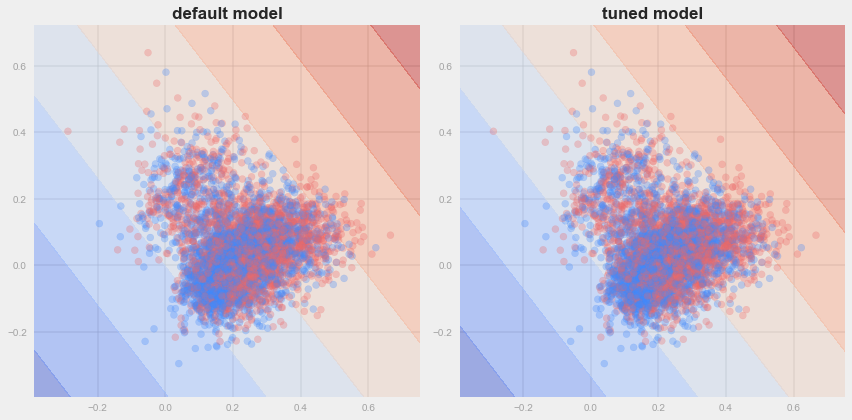

In [11]:
models_lr.compareDecisionContour('factorAnalysis', [3,4], alpha=0.3)

In general, a linear classifier like logistic regression is too simple to achieve high accuracy even if we map the features into quadratic polynomial space. Thus the tuning of hyperparameters doesn't change the behavior of classifier a lot. 

If we map them into higher dimensional space, the computation becomes expensive. This leads us to the support vector machine which deals with higher dimensional space more efficiently using kernel trick.

# 3. SVM:

The main problem we have in previous 2 classifiers is about the features, they are not predictive enough. When we couldn't find more features, we can try to combine the existing ones in some mathmetical ways hoping to find some of them separating the classes well. And SVM helps us do this with kernel trick.

### Tune model in different feature space:

Grid search is performed on parameters:
    
    1. kernel type: ['poly'(degree=3), 'rbf']
    2. Error penalty(C): [10**1, 10**1.5, 10**2.0, 10**2.5, 10**3.5]
    3. Kernel coefficient(gamma): [10**-3.0, 10**-2.0, 10**-1.5, 10**-1.0]

In [12]:
params_svc = {
    'kernel':['poly', 'rbf'],
    'C':(10**1, 10**1.5, 10**2.0, 10**2.5, 10**3.5), 
    'gamma':(10**-3.0, 10**-2.0, 10**-1.5, 10**-1.0),
    'probability':[True]
}

# models_svc = lp(svc, 'SVM', Xs_train, y_train)
# models_svc.gridSearching(params=params_svc)
# models_svc.results = models_svc.results.drop('probability', axis=1)

with open('data/performances/models_svc.pickle', 'rb') as f:
    models_svc = pickle.load(f)

Looking at the 10 best models, we can see the performance is not better than logistic regression. But the variances in sparsePCA feature space are all low.

In [13]:
models_svc.results.head(n=10)

C                                      confusionHist  \
0  3162.277660  [[[0.000379939209726, 0.0887950708657, 1.64103...   
1  3162.277660  [[[0.00600788595652, 0.144539206722, 1.2733776...   
2  3162.277660  [[[0.00192961187518, 0.104260420873, 1.5700644...   
3  3162.277660  [[[0.0011706816991, 0.0744030102416, 1.6157046...   
4   100.000000  [[[0.00224427536103, 0.158787976266, 1.3554865...   
5  3162.277660  [[[0.000756430733885, 0.0761338648266, 1.61024...   
6   316.227766  [[[0.00301090647797, 0.162264096064, 1.2846455...   
7   316.227766  [[[0.00116752355166, 0.080180954468, 1.7683430...   
8  3162.277660  [[[0.00412590783811, 0.15968917288, 1.25890338...   
9   316.227766  [[[0.0, 0.0557643933027, 1.65916977873, 1.8131...   

   expectedLoss     gamma kernel      mean           space  variance  
0      0.117958  0.100000   poly  0.656565       sparsePCA  0.000011  
1      0.118011  0.100000    rbf  0.656523  factorAnalysis  0.000034  
2      0.118280  0.100000   poly  0.656141        original  0.000041  
3      0.118310  0.100000    rbf  0.656099        original  0.000042  
4      0.118648  0.100000    rbf  0.655590  factorAnalysis  0.000030  
5      0.118675  0.100000    rbf  0.655548       sparsePCA  0.000027  
6      0.119298  0.100000    rbf  0.654658  factorAnalysis  0.000037  
7      0.119881  0.100000    rbf  0.653852        original  0.000063  
8      0.119911  0.031623    rbf  0.653768  factorAnalysis  0.000034  
9      0.120266  0.100000    rbf  0.653217       sparsePCA  0.000007

For each of the hyperparameters:
- **Feature Space**: Except PCA and NMF feature spaces, all other spaces have models achieve good result. And they are evenly distributed in the top 10.
- **Kernel Type**: Most of the good models use rbf as the kernel although polynomial kernel can produce good result when the other hyperparameters are set right.
- **Error Penalty(C)**: In general, the dataset requires high error penality.
- **Kernel Coefficient(gamma)**: Also high kernel coefficients are prefered which gives higher flexibility and less smooth decision boundaries. 

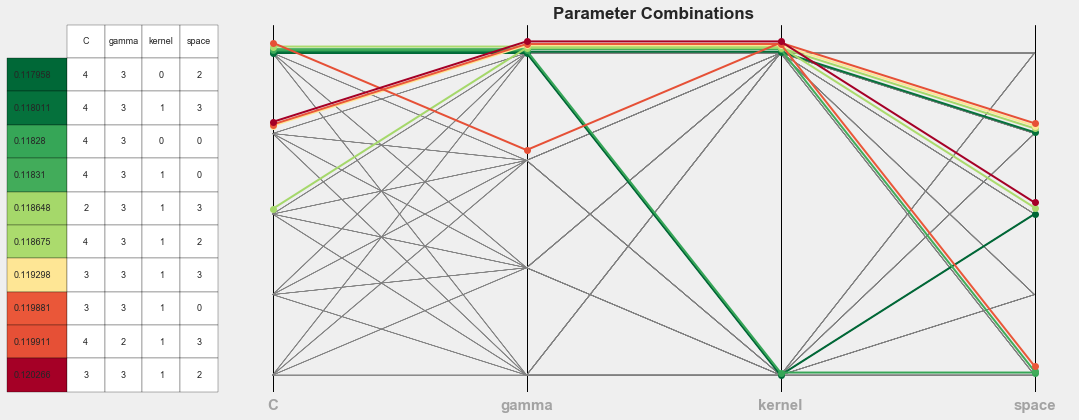

In [14]:
models_svc.plotParamGrid(params_svc)

But the decision boundary plotting renders the classifiers almost useless because most of these svm models label most of the data points as unpopular. We will investigate this issue more by looking at positive and negative predictions in model selection section.

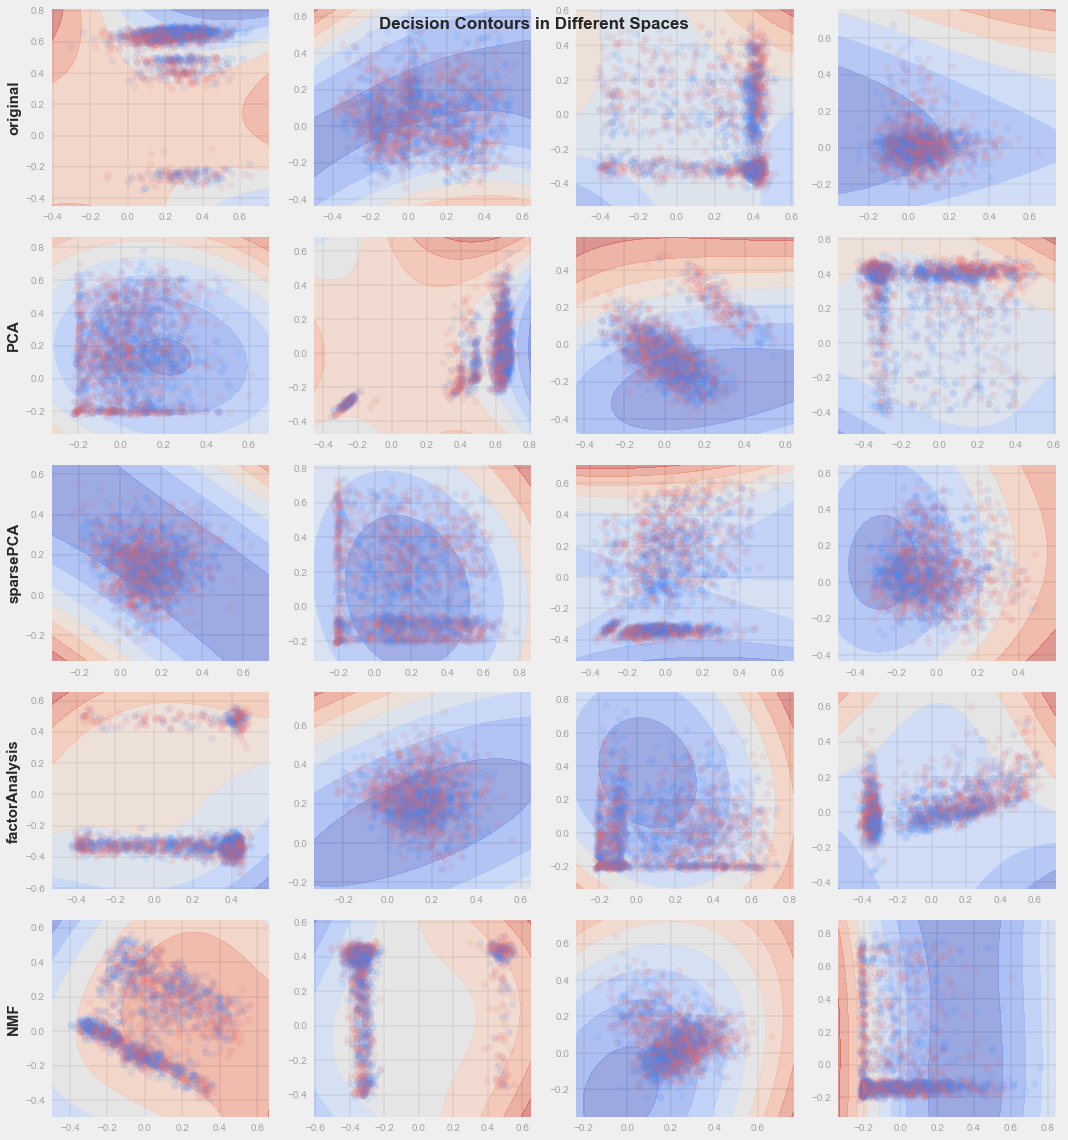

In [15]:
models_svc.plotDecisionContours(dimPairs, 4)

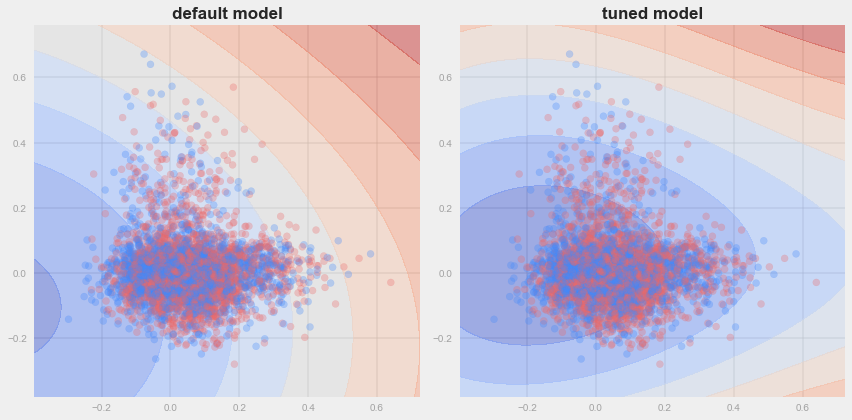

In [16]:
models_svc.compareDecisionContour('factorAnalysis', [3,4], alpha=0.3)

# 4. k-Nearest Neighbor:

So far we have tested 3 classifiers, and the best ones are SVM(questionable) and logistic regression. But still, we hope to find models that predict better. What is in common about those 3 classifiers is that they are all feature-based. In other words, we have been manipulating features in different ways to make prediction. Maybe there is a limitation of this method for our dataset. So this time, we will try KNN which is instance-based, so that every prediction will be made by checking surrounding data points whose labels are already known. And this model has a very high representability.

### Tune model in different feature space:

Grid search is performed on parameters:
    
    1. Number of neighbors: [20, 40, 80, 160]
    2. Weighting methods: ['uniform', 'distance']
    3. Distance metric: ['manhattan', 'euclidean', 'minkowski']

In [17]:
params_knn = {
    'n_neighbors':[20, 40, 80, 160],
    'weights':['uniform', 'distance'],
    'metric':['manhattan', 'euclidean', 'minkowski']
}

# models_knn = lp(knn, 'k-NearestNeighbors', Xs_train, y_train)
# models_knn.gridSearching(params=params_knn)

with open('data/performances/models_knn.pickle', 'rb') as f:
    models_knn = pickle.load(f)

Among the models in this family, the pattern of performances are quite different from the previous models. The accuracies are not as high as svm models in general, but the variances are all low, thus the expected loss are low. 

In [18]:
models_knn.results.head(n=10)

confusionHist  expectedLoss      mean  \
0  [[[0.00289594077213, 0.376299626788, 1.4149334...      0.122992  0.649318   
1  [[[0.00220212156108, 0.342774643373, 1.4459647...      0.124241  0.647537   
2  [[[0.00107327649069, 0.357597881515, 1.3209880...      0.124488  0.647198   
3  [[[0.0, 0.241097833932, 1.44592980513, 1.60238...      0.124672  0.646944   
4  [[[0.0, 0.211394298873, 1.43239326571, 1.58360...      0.124893  0.646605   
5  [[[0.000703731945976, 0.381487775565, 1.324184...      0.125264  0.646097   
6  [[[0.0, 0.210099000834, 1.37064768828, 1.51325...      0.126367  0.644528   
7  [[[0.0, 0.237732302813, 1.37736269553, 1.54741...      0.126465  0.644401   
8  [[[0.0177161114129, 0.568536246675, 1.17217462...      0.126741  0.644020   
9  [[[0.0444916096252, 0.526807681713, 1.34089521...      0.126941  0.643765   

      metric  n_neighbors      space  variance   weights  
0  manhattan           80   original  0.000014  distance  
1  manhattan           80  sparsePCA  0.000012  distance  
2  manhattan           80  sparsePCA  0.000019   uniform  
3  manhattan          160   original  0.000023  distance  
4  manhattan          160  sparsePCA  0.000005  distance  
5  manhattan           80   original  0.000016   uniform  
6  manhattan          160  sparsePCA  0.000007   uniform  
7  manhattan          160   original  0.000014   uniform  
8  manhattan           40   original  0.000019   uniform  
9  manhattan           40   original  0.000038  distance

For each of the hyperparameters:
- **Feature Space**: This time, only the models in original space and sparsePCA space work well.
- **Number of Neighbors**: The best number of neighbors are around 80. 
- **Weighting Methods**: Whether using a distance weighting or uniform weighting for known data points seems irrelevant.
- **Distance Metric**: All the models favor the manhattan distance rather than the other 2.

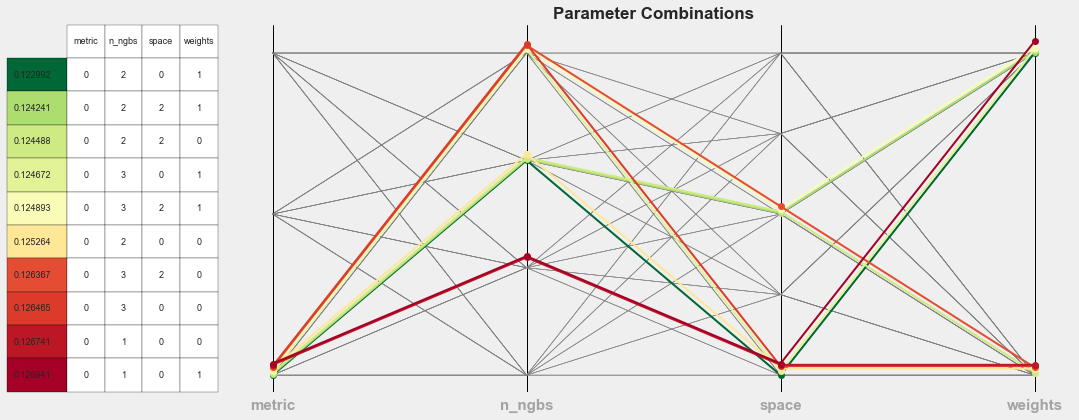

In [19]:
replaceCol = {'n_neighbors':'n_ngbs'}
models_knn.plotParamGrid(params_knn, replace=replaceCol)

In general, benefit from its high representability, the knn models are able to separate the mixed data points better than the other models. This matchs the decision boundary plotting below, the boundaries are rough thus captures finer pattern. 

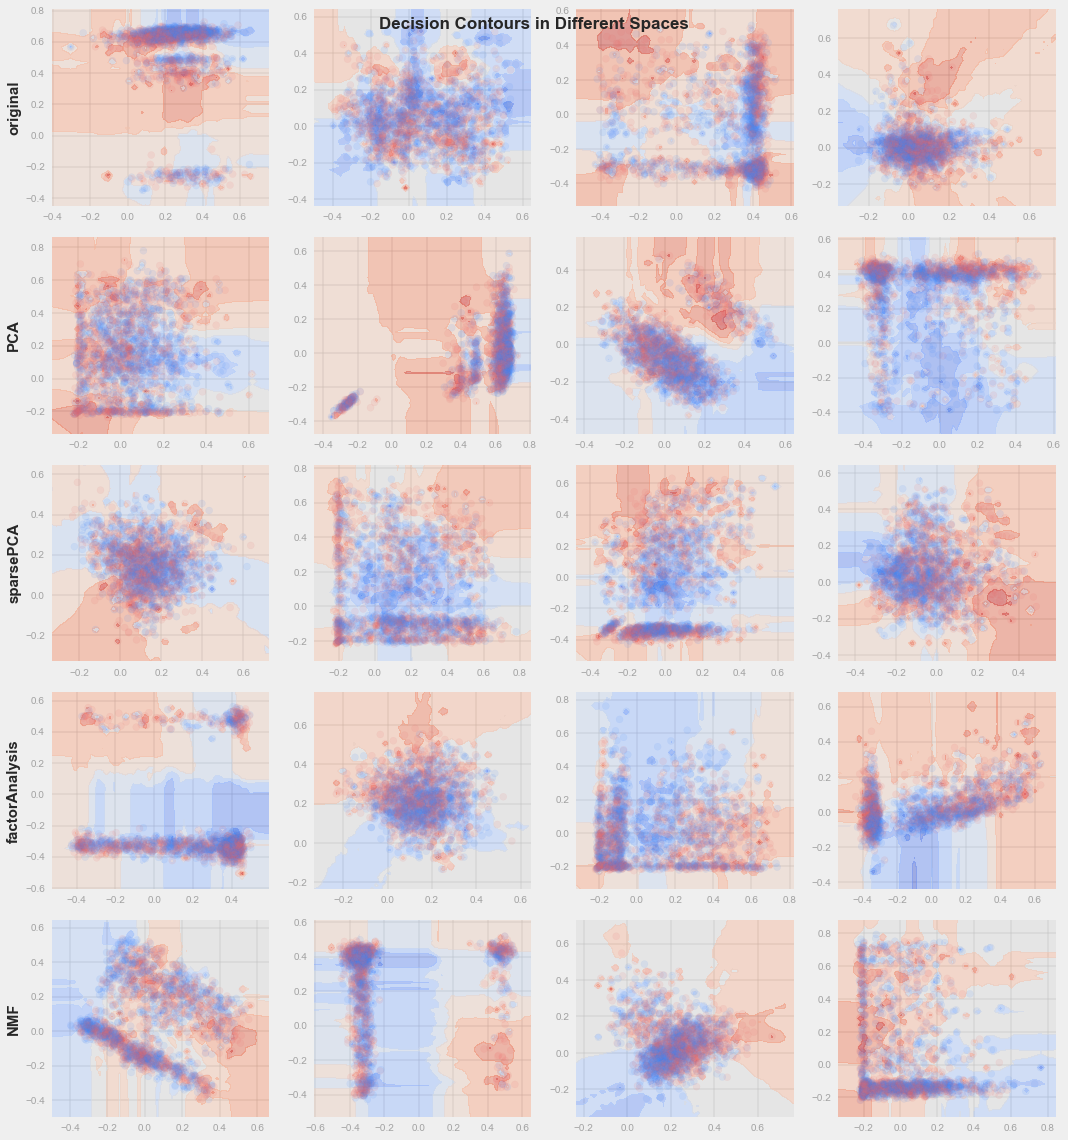

In [20]:
models_knn.plotDecisionContours(dimPairs, 4)

By comparing the models before and after the hyperparameter tuning, we can see the decision boundary are smoothened mainly due to the increasing of neighbor number. Thus the models are less prone to overfitting.

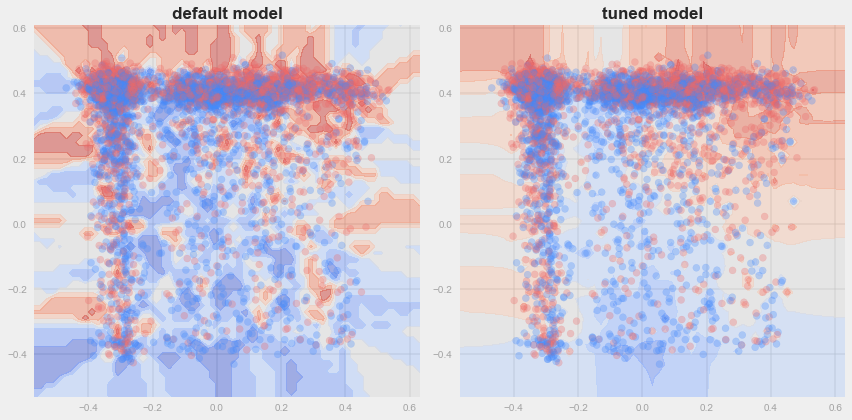

In [21]:
models_knn.compareDecisionContour('sparsePCA', [3,4], alpha=0.3)

# 5. Random Forest Classifier:

After trying both feature-based classifiers and instance-based classifiers, the performances are still not satisfying enough. We will try ensemble method which combines the decision of multiple classifiers. So the rest 2 classifiers we are testing, random forest and extra gradient boosting, are both tree based emsemble classifiers. The former one, random forest classifier simply combines decision by averaging the predictions of an assigned number of tree classifiers. And the latter one, extra gradient boosting, focus more on the data points which are difficult to classify.

### Tune model in different feature space:

Grid search is performed on parameters:
    
    1. Number of trees: [100, 200, 400, 800, 1600]
    2. Maximal depth of each tree: [10, 20, 30]
    3. Minimal leaf node sample size: [2, 5, 10, 20, 40]

In [22]:
params_rf = {
    'n_estimators':(100, 200, 400, 800, 1600),
    'max_depth':(5, 10, 20, 30),
    'min_samples_split':(2, 5, 10, 20, 40)
}

# models_rf = lp.LearningPipe(rf, 'RandomForest', Xs_train, y_train)
# models_rf.gridSearching(params=params_rf)

with open('data/performances/models_rf.pickle', 'rb') as f:
    models_rf = pickle.load(f)

Investigaitng the performances, the random forest models are indeed doing quite well. The accuracies are all over 66% thus the expected loss are lower. Although the variances are higher than the other model families.

In [23]:
models_rf.results.head(n=10)

confusionHist  expectedLoss  max_depth  \
0  [[[0.0220584116878, 0.502187223748, 1.07954327...      0.114308         20   
1  [[[0.0261469036003, 0.501172081051, 1.06839878...      0.114611         30   
2  [[[0.0278301221244, 0.502842313003, 1.05661451...      0.114936         30   
3  [[[0.0, 0.291849287132, 1.18748243373, 1.54210...      0.114952         10   
4  [[[0.0232335983547, 0.512346276186, 1.06061970...      0.115050         20   
5  [[[0.0, 0.282533564103, 1.16075295426, 1.55955...      0.115179         10   
6  [[[0.0, 0.273897115376, 1.15389896474, 1.56969...      0.115230         10   
7  [[[0.0275620593098, 0.449024672487, 1.09259806...      0.115266         30   
8  [[[0.0, 0.287599367746, 1.16264819087, 1.55671...      0.115266         10   
9  [[[0.0215155875472, 0.466662192119, 1.09551035...      0.115402         20   

       mean  min_samples_split  n_estimators      space  variance  
0  0.661990                 40          1600   original  0.000058  
1  0.661524                 40          1600   original  0.000045  
2  0.661058                 40           800   original  0.000055  
3  0.661015                 10           200   original  0.000041  
4  0.660888                 40           800   original  0.000054  
5  0.660676                 20           800   original  0.000039  
6  0.660591                 40           400   original  0.000032  
7  0.660549                 20           800  sparsePCA  0.000039  
8  0.660549                 10          1600   original  0.000039  
9  0.660337                 20           400  sparsePCA  0.000031

For each of the hyperparameters:
- **Feature Space**: For random forest classifiers, the original feature space stands out occupying 8 out of top 10.
- **Number of trees**: In general, more trees will result in higher performance.
- **Maximal depth of each tree**: The best depth are around 20. 
- **Minimal leaf node sample size**: And larger leaf sizes are better which gives more smooth decision boundaries.

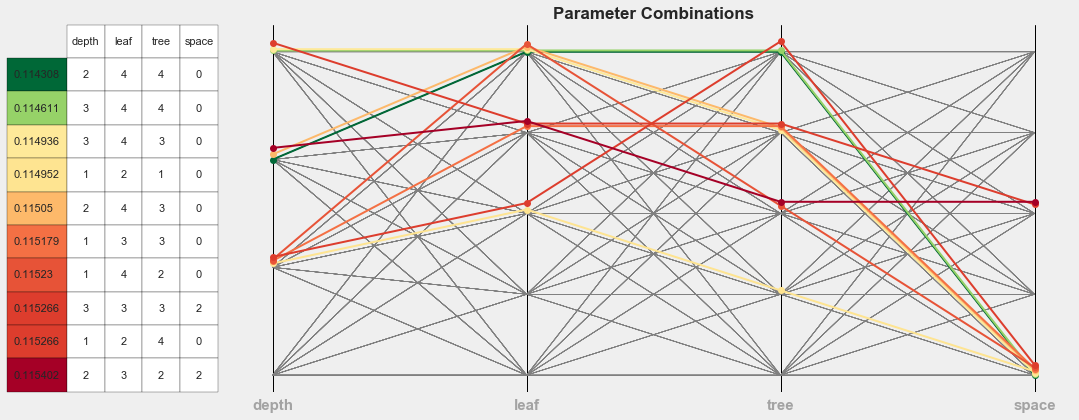

In [24]:
replaceCol = {'max_depth':'depth', 'min_samples_split':'leaf', 'n_estimators':'tree'}
models_rf.plotParamGrid(params_rf, replace=replaceCol)

Similar to naive Bayes, tree classifiers look at only one feature at one time so the decision boundaries are distributed parallel to the axes. But because random forest are combining decisions of many trees, so the model is much more flexible than the naive Bayes.

Compared with default model, we have much more trees in the forest and the leaf size are much bigger. Thus the decision boundary are much smoother.

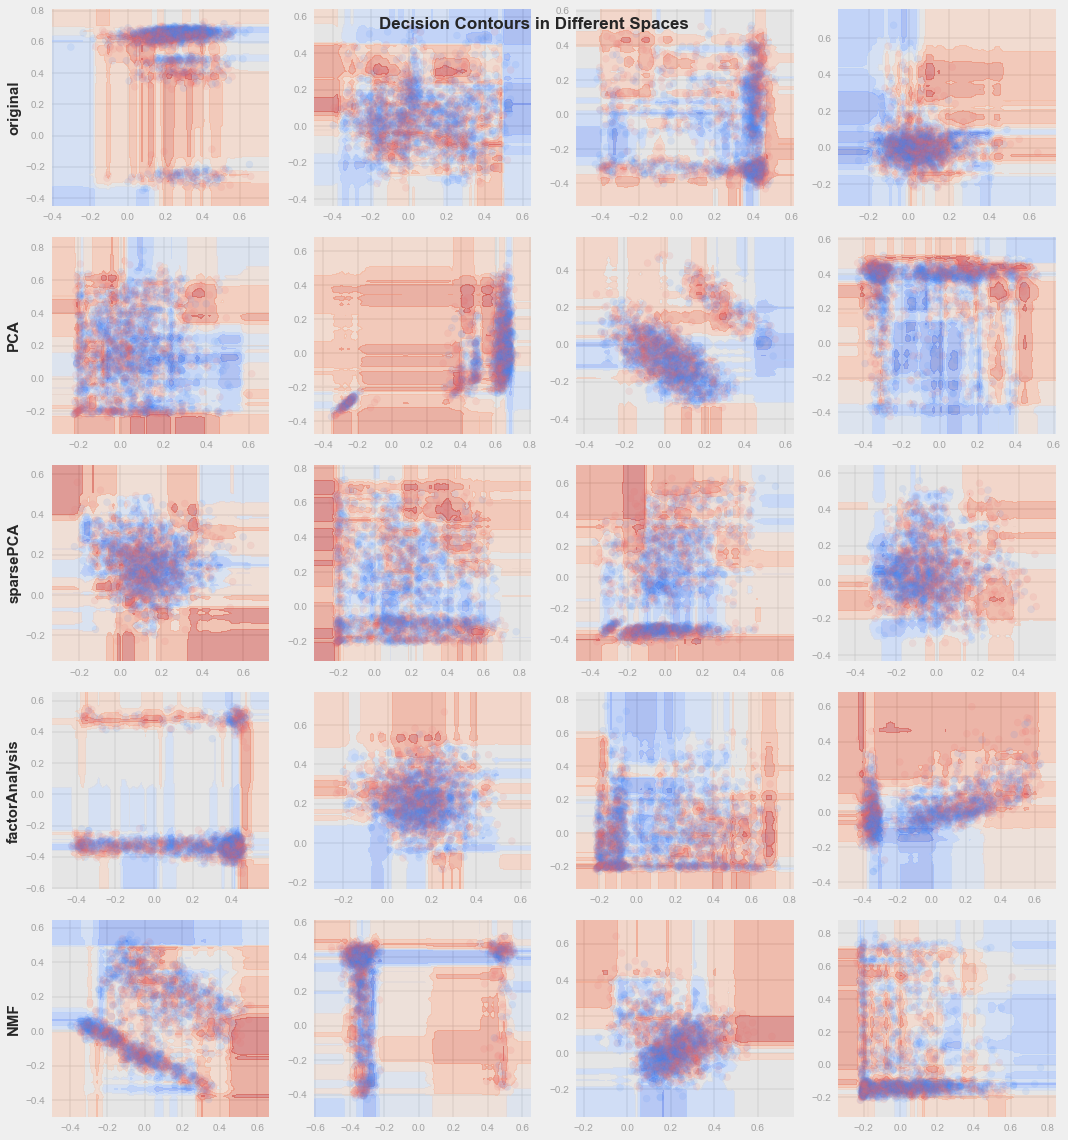

In [25]:
models_rf.plotDecisionContours(dimPairs, 4)

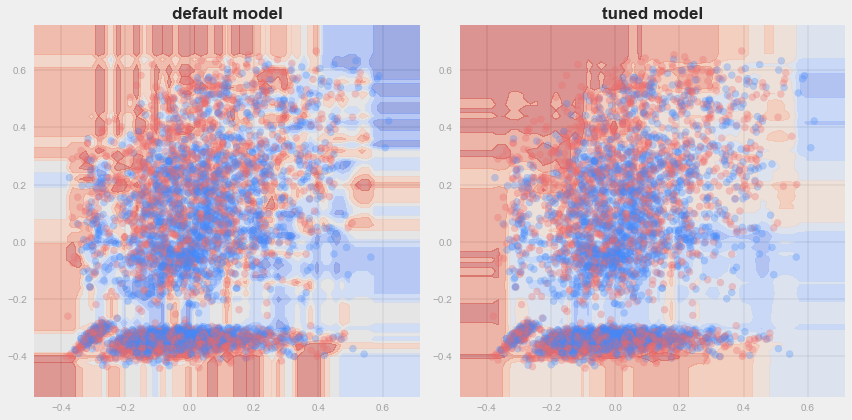

In [26]:
models_rf.compareDecisionContour('original', [2,3], alpha=0.3)


# 7. XGBoost:

The extra gradient boost is a popular emsemble model. By starting from simple classifiers, it keeps adding new tree classifiers based on the wrong predictions.

### Tune model in different feature space:

Grid search is performed on parameters:
    
    1. Subsample ratio of each time of fitting: [0.2, 0.5, 0.8, 1]
    2. Minimum loss reduction required to make a split(gamma): [0, 0.2, 0.5, 1]
    3. Coefficient of L1 regularization(alpha): [0.001, 0.01, 0.1, 1]

In [27]:
params_xgb = {
    'subsample':[0.2, 0.5, 0.8, 1],
    'gamma':[0, 0.2, 0.5, 1],
    'reg_alpha':[0.001, 0.01, 0.1, 1],
    'silent':[1],
    'nthread':[4],
    'objective':['binary:logistic']
}
    
# models_xgb = lp.LearningPipe(xgb, 'ExtraGradientBoost', Xs_train, y_train)
# models_xgb.gridSearching(params=params_xgb)
# models_xgb.results = models_xgb.results.drop(['nthread', 'objective', 'silent'], axis=1)

with open('data/performances/models_xgb.pickle', 'rb') as f:
    models_xgb = pickle.load(f)

Shown in the performance evaluations of extra gradient boost classfiers, the accuracies are even higher than the random forest classifiers but the variances are also high. High variances seems to be a common problem of emsemble methods on this dataset.

In [28]:
models_xgb.results.head(n=10)

confusionHist  expectedLoss  gamma  \
0  [[[0.00280291919723, 0.491836057934, 1.2924220...      0.112557    0.0   
1  [[[0.00520629916723, 0.473193533978, 1.2957464...      0.112644    0.5   
2  [[[0.00804157072994, 0.425289703701, 1.2904108...      0.112686    0.0   
3  [[[0.00561041843199, 0.473207398, 1.2924828766...      0.112731    0.0   
4  [[[0.00600598356376, 0.470202048573, 1.2954661...      0.112731    0.2   
5  [[[0.00842025112265, 0.414067920707, 1.2946508...      0.112740    1.0   
6  [[[0.00803586854682, 0.425095829475, 1.2874799...      0.112827    0.2   
7  [[[0.0100699887571, 0.41373138994, 1.281406282...      0.112853    1.0   
8  [[[0.0100394864631, 0.417017124116, 1.28320591...      0.112853    0.0   
9  [[[0.00923303946175, 0.417904934692, 1.2830054...      0.112910    0.2   

       mean  reg_alpha     space  subsample  variance  
0  0.664575      1.000  original        0.8  0.000048  
1  0.664448      0.001  original        0.8  0.000049  
2  0.664364      0.100  original        1.0  0.000034  
3  0.664321      0.001  original        0.8  0.000051  
4  0.664321      0.001  original        0.8  0.000051  
5  0.664279      1.000  original        1.0  0.000031  
6  0.664152      0.100  original        1.0  0.000033  
7  0.664109      0.001  original        1.0  0.000030  
8  0.664109      0.010  original        1.0  0.000030  
9  0.664025      0.010  original        1.0  0.000030

For each of the hyperparameters:
- **Feature Space**: All the top results are produced in original spaces.
- **subsample**: Most models prefer to use the whole training set at each round rather than take a subsample from it.
- **gamma**: The hyperparameter minimum loss(gamma) seems irrelevant for this dataset.
- **reg_alpha**: The coefficient of L1 regularization seems irrelevant for this dataset as well. All the possible values produce good performance.

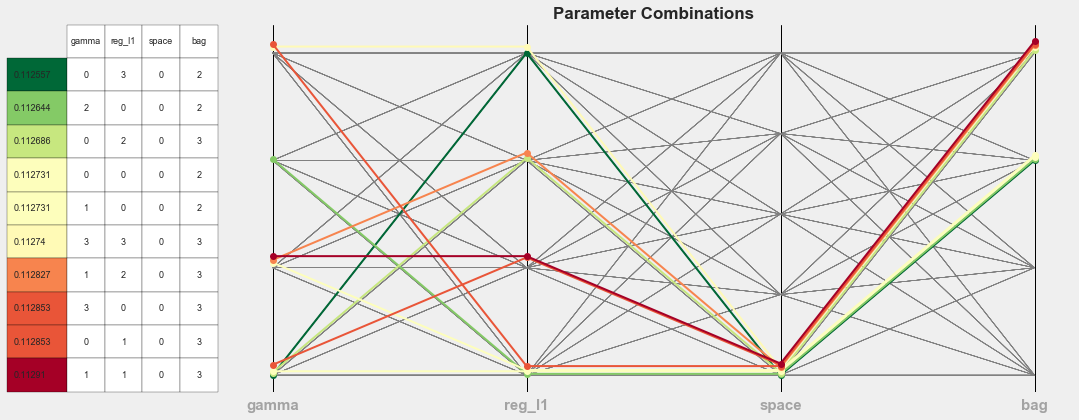

In [29]:
replaceCol = {'subsample':'bag', 'reg_alpha':'reg_l1'}
models_xgb.plotParamGrid(params_xgb, replace=replaceCol)

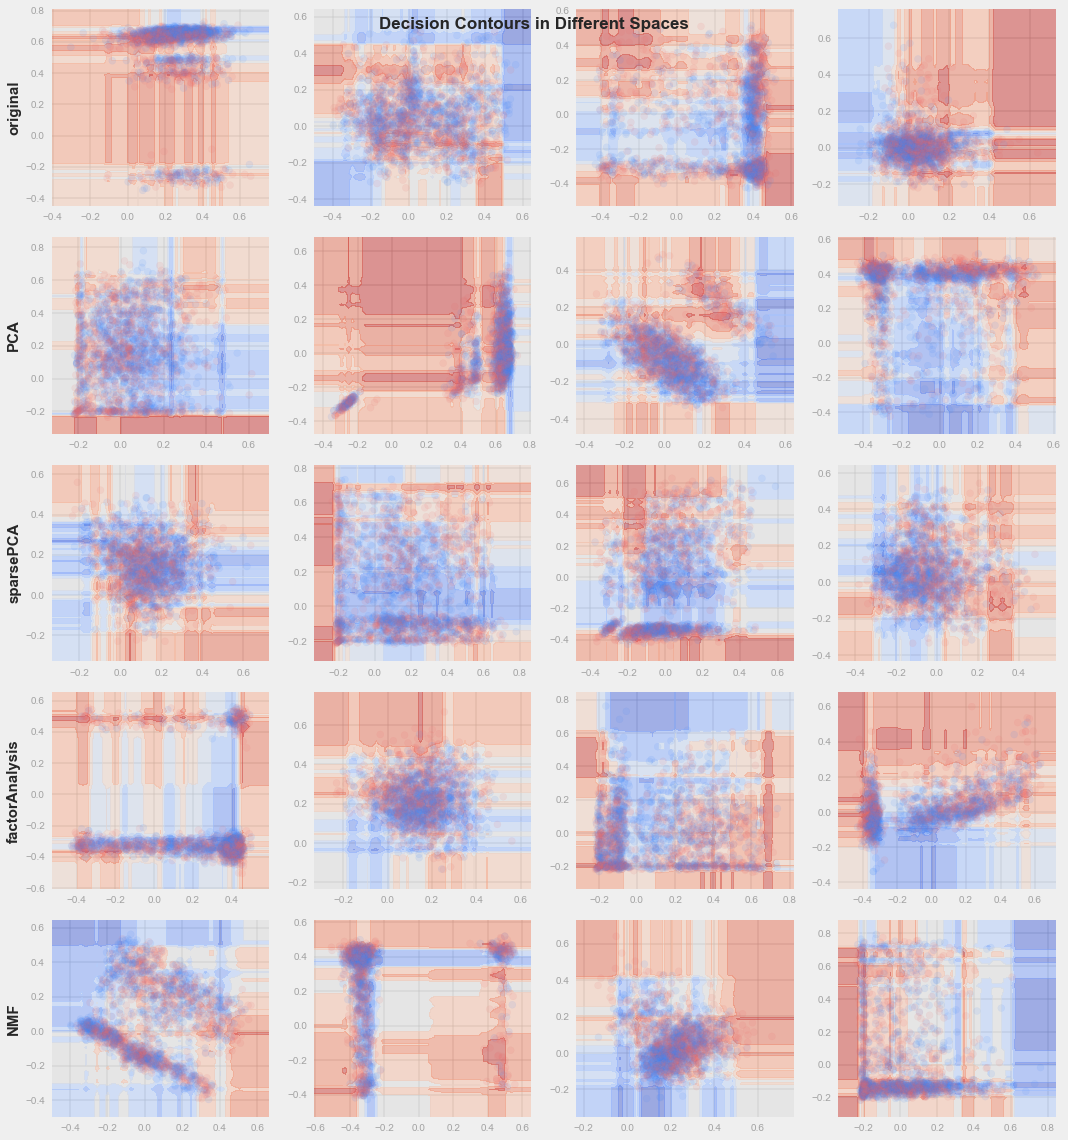

In [30]:
models_xgb.plotDecisionContours(dimPairs, 4)

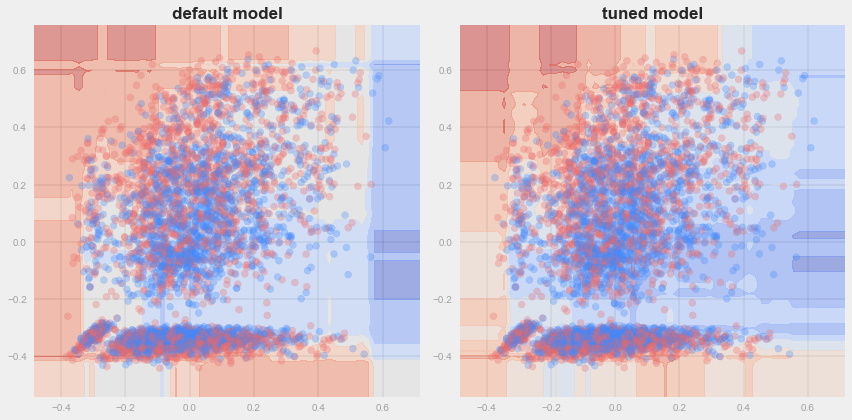

In [31]:
models_xgb.compareDecisionContour('original', [2,3], alpha=0.3)


# 8. Compare performance evaluations:

Taking one model out of each family in each feature space with best hyperparameter setting, we can plot them out and compare their performances visually.

In [32]:
models = [
    models_nb, models_lr, models_svc, models_knn, models_rf, models_xgb
]
performances = []
for model in models: performances.append(model.bestPerfs)
performances = pd.concat(performances, axis=0).reset_index()

In [33]:
# because mean accuracy, variance and expected loss are in different scale. 
# So we need to standardize them before showing them in the line plotting.
# standardize = lambda sr: (sr - sr.mean()) / (sr.max() - sr.min())

# visuallize loss var and bias 
# v = V(1, 1, figsize=(15, 8))
# v.plotLines(
#     performances.index, 
#     [standardize(performances['expectedLoss']), 
#      standardize(performances['mean']), 
#      standardize(performances['variance'])]
# )

![performance_compares](imgs/performance_compares.png)
Ideally, we should select models with high mean accuracy and low variances. Judging from the plotting we can easily tell naive Bayes are not good for us. Although the variances are not steady, the random forest and extra gradient boost have the lowest expected losses.

The best 10 models are listed below.

In [34]:
bestPerfs = performances.sort_values('expectedLoss')\
    .reset_index().head(n=12)
bestPerfs

level_0  index                                      confusionHist  \
0        25      0  [[[0.00280291919723, 0.491836057934, 1.2924220...   
1        20      0  [[[0.0220584116878, 0.502187223748, 1.07954327...   
2        22      2  [[[0.0275620593098, 0.449024672487, 1.09259806...   
3        27      2  [[[0.00117811073322, 0.384045292124, 1.3663824...   
4         8      3  [[[0.0541211065235, 0.678542385197, 1.24286203...   
5        12      2  [[[0.000379939209726, 0.0887950708657, 1.64103...   
6        13      3  [[[0.00600788595652, 0.144539206722, 1.2733776...   
7        10      0  [[[0.00192961187518, 0.104260420873, 1.5700644...   
8         7      2  [[[0.00389309635413, 0.457762374937, 1.3197440...   
9         5      0  [[[0.000389711613406, 0.374840181983, 1.263052...   
10       23      3  [[[0.00287328880347, 0.223311790992, 0.8293623...   
11       21      1  [[[0.0100843828201, 0.298008260487, 0.97696180...   

    expectedLoss      mean           space  variance                 clf  
0       0.112557  0.664575        original  0.000048  ExtraGradientBoost  
1       0.114308  0.661990        original  0.000058        RandomForest  
2       0.115266  0.660549       sparsePCA  0.000039        RandomForest  
3       0.116934  0.658091       sparsePCA  0.000032  ExtraGradientBoost  
4       0.117765  0.656862  factorAnalysis  0.000022  LogisticRegression  
5       0.117958  0.656565       sparsePCA  0.000011                 SVM  
6       0.118011  0.656523  factorAnalysis  0.000034                 SVM  
7       0.118280  0.656141        original  0.000041                 SVM  
8       0.119044  0.654997       sparsePCA  0.000017  LogisticRegression  
9       0.120003  0.653640        original  0.000038  LogisticRegression  
10      0.120580  0.652835  factorAnalysis  0.000057        RandomForest  
11      0.121137  0.651987             PCA  0.000024        RandomForest

### Decision Confidence Compare:
Remember the SVM classifiers have a issue of label most of data points as one class. To avoid selecting models have such kind of behavior, we need to investigate the confusion matrix. Here, we use confusion histograms, which are the detail version of confusion matrix, show us how confident those 10 classifiers are when they are making predictions and how many predictions are correct or wrong.

In [35]:
# v = V(3, 4, figsize=(18, 12))
# v.plotConfusionHists(
#     bestPerfs['confusionHist'], 
#     bestPerfs['clf'], 
#     bestPerfs['space']
# )

![confusion_histograms](imgs/confusion_histograms.png)

These confusion histograms assure us that none of these classifiers make unbalanced predictions. And when these classifiers make confident right predictions, they also make confident mistakes. None of them are obviously better than the others. So we may choose the one with lowest expected loss, which is extra gradient boost in original space, as our final model.